In [42]:
import statistics 
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import metrics

In [47]:
path_to_datasets = '../datasets'
path_to_cleaned = '/datasets_cleaned'

join_dataframe = pd.read_csv(f'{path_to_datasets}{path_to_cleaned}/join_dataframe.csv')
join_external_dataframe = pd.read_csv(f'{path_to_datasets}{path_to_cleaned}/join_external_dataframe.csv')

# numeric_columns_to_clusterize = ['incidents_state_year', 'severity_index',
#                                  'percentage_males', 'percentage_adults',
#                                  'age_combined_index', 'povertyPercentage',
#                                  'percentage_votes', 'n_killed', 'n_injured',
#                                  'n_unharmed', 'n_arrested', 'n_participants']

# categorical_columns_to_clusterize = ['state']

# incidents_num = join_dataframe[numeric_columns_to_clusterize].copy().sample(frac=0.4, random_state=42)
# incidents_cat = join_dataframe[categorical_columns_to_clusterize].copy().sample(frac=0.4, random_state=42)

# incidents_num.dropna(inplace=True)
# incidents_cat.dropna(inplace=True)

join_dataframe.dropna(inplace=True)
join_external_dataframe.dropna(inplace=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = None

We drop all null values as our datasets is still large and barely inside the limits of our computational capacity. Also the values that we drop are the ones that do not match between the povertyPercentage dataset and the incidents dataset.

### Filtering Small Cities

In [44]:
filter_year_incidents = join_dataframe[join_dataframe['year'].isin([2014, 2015, 2016, 2017])]

# Calculate minimum weeks required
total_weeks_in_4_years = 209
threshold_percentage = 15
min_weeks_required = total_weeks_in_4_years * (threshold_percentage / 100)

# Calculate total incidents per city per week
total_incidents = filter_year_incidents.groupby(['state', 'city_or_county', 'year', 'week']).size().reset_index(name='total_incidents')

# Calculate total weeks per city
total_weeks_per_city = total_incidents.groupby(['state', 'city_or_county']).size().reset_index(name='total_weeks')

# Filter cities based on minimum weeks required
filtered_cities = total_weeks_per_city[total_weeks_per_city['total_weeks'] >= min_weeks_required].copy()

# Filter incidents based on filtered cities
filtered_incidents = filter_year_incidents[filter_year_incidents['city_or_county'].isin(filtered_cities['city_or_county'])].copy()



In [45]:
# Calculate severity score
weight_killed = 2
weight_injured = 1
filtered_incidents['severity_score'] = (weight_killed * filtered_incidents['n_killed']) + (weight_injured * filtered_incidents['n_injured'])

# Identify incidents with at least one person killed
filtered_incidents['isKilled'] = filtered_incidents['n_killed'] != 0

# Create a 'year_week' column for sorting
filtered_incidents['year_week'] = list(zip(filtered_incidents['year'], filtered_incidents['week']))
filtered_incidents = filtered_incidents.sort_values(by='year_week')

# Create a DataFrame to store the final results
result_df = pd.DataFrame(index=filtered_cities['city_or_county'])

# Determine if more than half of the incidents in a city involve killings
result_df['isKilled'] = filtered_incidents.groupby('city_or_county')['isKilled'].mean() > 0.5

# Pivot table to get severity scores per city and week
filtered_cities = filtered_incidents.pivot_table(index='city_or_county', columns=['year', 'week'], values='severity_score', aggfunc='sum', fill_value=-1)

In [46]:
# Create a DataFrame to store the final results
result_df = pd.DataFrame(index=filtered_cities['city_or_county'])

# Determine if more than half of the incidents in a city involve killings
result_df['isKilled'] = filtered_incidents.groupby('city_or_county')['isKilled'].mean() > 0.5

KeyError: 'city_or_county'

### Incident Severity Score

In [ ]:
weight_killed = 2
weight_injured = 1

filtered_incidents['severity_score'] = (weight_killed * filtered_incidents['n_killed']) + (weight_injured * filtered_incidents['n_injured'])

In [ ]:
filtered_incidents['isKilled'] = filtered_incidents['n_killed'] != 0

filtered_incidents['year_week'] = list(zip(filtered_incidents['iso_year'], filtered_incidents['iso_week']))
filtered_incidents = filtered_incidents.sort_values(by='year_week')

filtered_incidents.head()

,Unnamed: 0,date,year,state,city_or_county,address,latitude,longitude,congressional_district,min_age_participants,avg_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,month,day,n_participants_child_ratio,n_participants_teen_ratio,n_participants_adult_ratio,n_males_ratio,n_females_ratio,n_killed_ratio,n_injured_ratio,n_unharmed_ratio,n_arrested_ratio,incidents_state,incidents_city,n_killed_percentage,n_injured_percentage,n_participants_teen_percentage,n_participants_child_percentage,population,density,Median Age,Male Population,Female Population,Number of Veterans,Foreign-born,Average Household Size,povertyPercentage,party,candidatevotes,totalvotes,candidatevotes_ratio,iso_year,iso_week,severity_score,isKilled,year_week
88110,88110,2014-01-05,2014,Connecticut,New Haven,NaN,41.30,-72.92,3.0,7.0,12.0,18.0,1.0,0.0,1.0,2.0,0.0,0,1,0.0,1.0,2.0,Shot - Wounded/Injured,1,5,0.5,0.0,0.5,1.0,0.0,0.0,0.5,0.5,0.0,3067,411,0.00,0.02,0.0,0.25,587648.0,2693.4,29.9,63765.0,66545.0,2567.0,25871.0,2.48,9.2,DEMOCRAT,130009.0,209939.0,0.62,2014,1,1,False,"(2014, 1)"
80962,80962,2014-01-03,2014,Arkansas,Little Rock,3100 W. Roosevelt Road,34.73,-92.31,2.0,23.0,23.0,23.0,0.0,0.0,2.0,1.0,1.0,0,1,0.0,1.0,2.0,Shot - Wounded/Injured,1,3,0.0,0.0,1.0,0.5,0.5,0.0,0.5,0.5,0.0,2842,929,0.00,0.01,0.0,0.00,457379.0,637.0,36.6,96997.0,100989.0,12343.0,16640.0,2.36,16.8,REPUBLICAN,123073.0,237330.0,0.52,2014,1,1,False,"(2014, 1)"
102710,102710,2014-01-05,2014,New York,Buffalo,Newfield Street,42.96,-78.90,26.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,0,0.0,0.0,1.0,"Shot - Dead (murder, accidental, suicide)",1,5,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,9712,954,0.02,0.00,NaN,NaN,1004655.0,2446.1,33.1,124537.0,133529.0,11231.0,24630.0,2.27,13.4,DEMOCRAT,100648.0,173911.0,0.58,2014,1,2,True,"(2014, 1)"
232019,232019,2014-01-01,2014,New Jersey,Belleville,Union Avenue,40.80,-74.16,8.0,23.0,23.0,23.0,0.0,1.0,1.0,1.0,0.0,0,0,0.0,2.0,2.0,Armed robbery with injury/death and/or evidenc...,1,1,0.0,0.5,0.5,0.5,0.0,0.0,0.0,1.0,0.0,5386,15,0.00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.7,DEMOCRAT,61510.0,79518.0,0.77,2014,1,0,False,"(2014, 1)"
80965,80965,2014-01-01,2014,Arkansas,Little Rock,1624 College Street,34.73,-92.26,2.0,48.0,48.0,48.0,0.0,0.0,3.0,3.0,0.0,0,0,0.0,3.0,3.0,Home Invasion,1,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2842,929,0.00,0.00,0.0,0.00,457379.0,637.0,36.6,96997.0,100989.0,12343.0,16640.0,2.36,16.8,REPUBLICAN,123073.0,237330.0,0.52,2014,1,0,False,"(2014, 1)"


In [ ]:
filtered_incidents_killed = filtered_incidents[['city_or_county', 'isKilled']].copy()
filtered_incidents_killed.set_index('city_or_county', inplace=True)

filtered_incidents_killed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151466 entries, New Haven to Little Rock
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   isKilled  151466 non-null  bool 
dtypes: bool(1)
memory usage: 1.3+ MB


In [ ]:
grouped_data = filtered_incidents_killed.groupby('city_or_county')['isKilled'].value_counts().unstack()

result_df = pd.DataFrame(index=grouped_data.index)

result_df['isKilled'] = grouped_data[True] > grouped_data[False] / 2

result_df.value_counts()

isKilled
False       499
True         90
Name: count, dtype: int64

In [ ]:
# filtered_incidents_is_killed = filtered_incidents[['year_week', 'isKilled']].copy()
# filtered_incidents_is_killed.drop_duplicates(inplace=True)
# filtered_incidents_is_killed.set_index('year_week', inplace=True)

In [ ]:
# filtered_cities = filtered_incidents[['city_or_county', 'year_week', 'severity_score']].copy()
# filtered_cities = filtered_incidents.pivot_table(index='city_or_county', columns='year_week', values='severity_score', aggfunc='sum', fill_value=-1)
# filtered_cities.rename_axis(columns=None, inplace=True)
# filtered_cities.reset_index(drop=False, inplace=True)

In [ ]:
# -------------------------------------

In [ ]:
filtered_cities = filtered_incidents.pivot_table(index='city_or_county', columns=['iso_year', 'iso_week'], values='severity_score', aggfunc='sum', fill_value=-1)
# filtered_cities = filtered_incidents.pivot_table(index='city_or_county', columns=['year_week'], values='severity_score', aggfunc='sum', fill_value=-1)

filtered_cities.head()

iso_year       2014                                                           \
iso_week         1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20   
city_or_county                                                                 
Abilene          -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1   
Aiken            -1  0 -1 -1 -1 -1 -1 -1 -1  2  0  0 -1 -1 -1 -1 -1  0  2 -1   
Akron            -1 -1 -1  3 -1 -1 -1 -1 -1  2 -1  1  1  0  1  1  0 -1  0 -1   
Albany            1 -1  6 -1  0 -1  4  1  0 -1  3 -1  1 -1  1  2  2  3  4  2   
Albert Lea       -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1   

iso_year                                                                       \
iso_week       21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41   
city_or_county                                                                  
Abilene        -1  1  4  4 -1 -1  1 -1 -1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1  0   
Aiken          -1 -1  2 -1 -1  1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1  0  0   
Akron           3  0  2  2  6 -1  1  5  3  4  5  0  0  2 -1  2  3  2  0  1  0   
Albany          0  1  2 -1  3  3  1  2  2  2  2 -1  0  0  0  2  0  2  0  5  0   
Albert Lea     -1 -1  0 -1 -1 -1 -1 -1  0 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1 -1   

iso_year                                        2015                          \
iso_week       42 43 44 45 46 47 48 49 50 51 52   1  2  3  4  5  6  7  8  9    
city_or_county                                                                 
Abilene        -1 -1  0 -1 -1 -1 -1 -1 -1 -1  2   -1 -1 -1 -1 -1  0 -1 -1 -1   
Aiken           1  1  1 -1 -1  4 -1  1  0 -1  0    0  1 -1  1  0  0 -1  0  0   
Akron          -1 -1 -1  2  8  0 -1  0 -1  0 -1    0  2  2  1  0 -1  2 -1  0   
Albany          5  1  1  1  1  0 -1 -1  2  1  0    0  0  0  1  0  2 -1 -1  0   
Albert Lea     -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1   -1 -1 -1  0 -1 -1 -1 -1 -1   

iso_year                                                                       \
iso_week       10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30   
city_or_county                                                                  
Abilene         1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1  0  2 -1 -1 -1 -1  2 -1 -1  2   
Aiken           0  0  0  0  1  6  0  0  0  3  0  0  0  1  0  2 -1  0 -1  0  0   
Akron          -1 -1  1  0  0  1 -1  1  1  1  7  1  4  0  0 -1  1  3 -1  3 -1   
Albany          5  0  0 -1  1 -1  3  0  4  5  0  2  0  2 -1  3  1  2 -1  2  5   
Albert Lea     -1  0 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1   

iso_year                                                                       \
iso_week       31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51   
city_or_county                                                                  
Abilene        -1 -1 -1 -1 -1 -1  1  0 -1 -1 -1 -1 -1  0 -1  0 -1 -1 -1 -1 -1   
Aiken          -1 -1  0  1 -1 -1 -1  0 -1 -1 -1  0 -1 -1  0  2 -1  2  0  0 -1   
Akron           5  5  1  3 -1  1 -1 -1  6  5 -1  0  4  0  4  2  4  1  4  2  4   
Albany          1  3  2  3  4  1  4 -1  3 -1  2  0  1  1  0  2  5  0  3  3  2   
Albert Lea     -1  0 -1 -1 -1 -1  0  1  2 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1   

iso_year             2016                                                     \
iso_week       52 53   1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18   
city_or_county                                                                 
Abilene        -1 -1    1  0  1  2  1  1 -1  1  1 -1  1 -1 -1 -1  3  0  0 -1   
Aiken           1  2    0 -1  1  4 -1  0  0 -1 -1  3  5  0 -1 -1  1 -1  1 -1   
Akron           2  3    3  2  4  4  2  3  0  0  4  2  2  1  3  0  0 -1  4  1   
Albany          1  3    0  0  0  2  1  1  0  0  2  1  1  1  0  0  4  3 -1 -1   
Albert Lea     -1 -1   -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0 -1  0  0   

iso_year                                                                       \
iso_week       19 20 21 22 23 24 25 26 27 28 29 3

In [ ]:
filtered_cities.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589 entries, Abilene to Yuma
Columns: 209 entries, (2014, 1) to (2017, 52)
dtypes: int64(209)
memory usage: 966.3+ KB


### Time Series Analysis

In [ ]:
time_series = filtered_cities.stack(level=['iso_year', 'iso_week'])

# Reset the index to make iso_year and iso_week part of the DataFrame
time_series = time_series.reset_index()

# Rename the columns for clarity
time_series.columns = ['city_or_county', 'iso_year', 'iso_week', 'severity_score']

# Display the resulting time series DataFrame
print(time_series)

       city_or_county  iso_year  iso_week  severity_score
0             Abilene      2014         1            -1.0
1             Abilene      2014         2            -1.0
2             Abilene      2014         3            -1.0
3             Abilene      2014         4             1.0
4             Abilene      2014         5            -1.0
...               ...       ...       ...             ...
123096           Yuma      2017        48             2.0
123097           Yuma      2017        49            -1.0
123098           Yuma      2017        50             3.0
123099           Yuma      2017        51             3.0
123100           Yuma      2017        52            -1.0

[123101 rows x 4 columns]


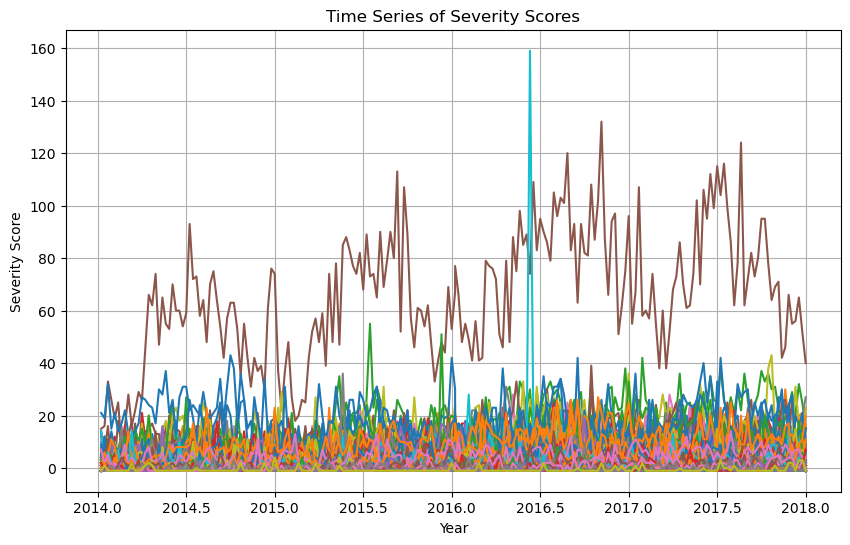

In [ ]:
plt.figure(figsize=(10, 6))
for city in time_series['city_or_county'].unique():
    city_data = time_series[time_series['city_or_county'] == city]
    plt.plot(city_data['iso_year'] + city_data['iso_week'] / 52, city_data['severity_score'], label=city)

plt.title('Time Series of Severity Scores')
plt.xlabel('Year')
plt.ylabel('Severity Score')
plt.grid(True)
plt.show()

### Offset Translation

In [ ]:
time_series_analysed = time_series.copy()

avg_severity_by_city = time_series_analysed.groupby('city_or_county')['severity_score'].transform('mean')

time_series_analysed['severity_score'] = time_series_analysed['severity_score'] - avg_severity_by_city

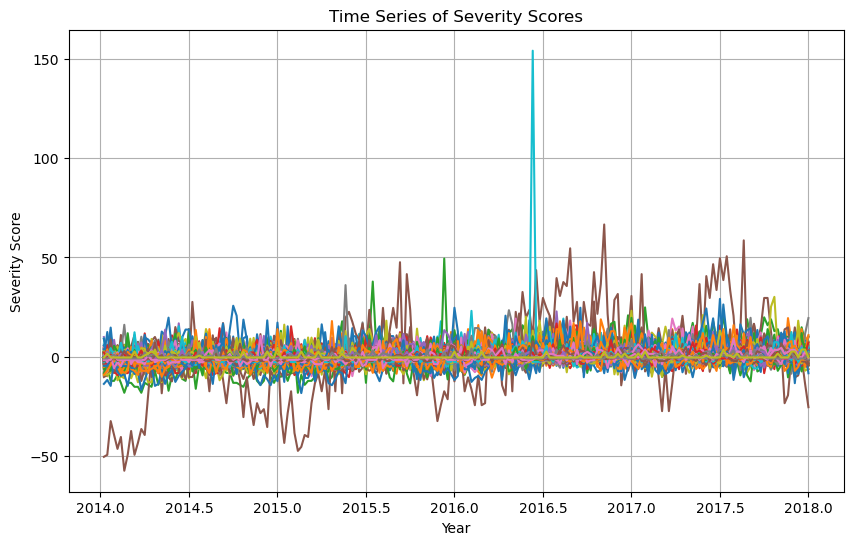

In [ ]:
plt.figure(figsize=(10, 6))
for city in time_series_analysed['city_or_county'].unique():
    city_data = time_series_analysed[time_series_analysed['city_or_county'] == city]
    plt.plot(city_data['iso_year'] + city_data['iso_week'] / 52, city_data['severity_score'], label=city)

plt.title('Time Series of Severity Scores')
plt.xlabel('Year')
plt.ylabel('Severity Score')
plt.grid(True)
plt.show()

### Amplitude Scaling

In [ ]:
time_series_analysed = time_series.copy()

mean_severity_by_city = time_series_analysed.groupby('city_or_county')['severity_score'].transform('mean')
std_severity_by_city = time_series_analysed.groupby('city_or_county')['severity_score'].transform('std')

time_series_analysed['severity_score'] = ( time_series_analysed['severity_score'] - mean_severity_by_city ) / std_severity_by_city

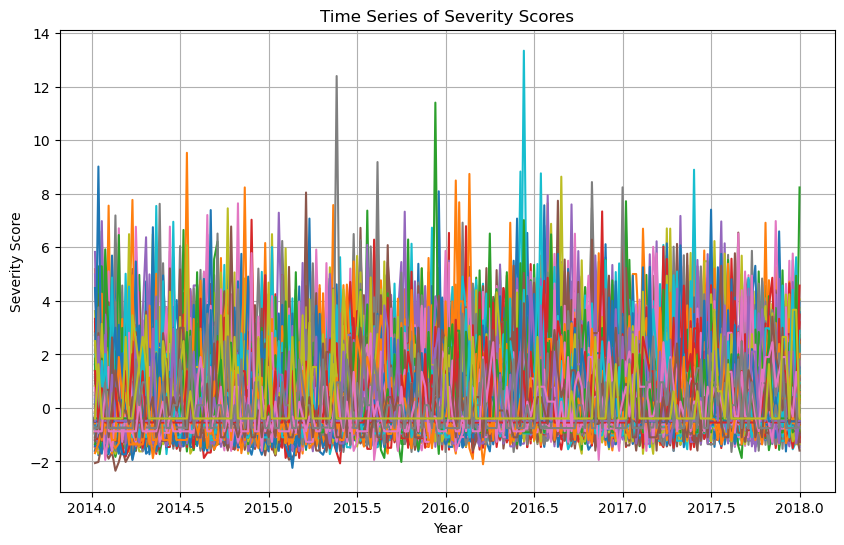

In [ ]:
plt.figure(figsize=(10, 6))
for city in time_series_analysed['city_or_county'].unique():
    city_data = time_series_analysed[time_series_analysed['city_or_county'] == city]
    plt.plot(city_data['iso_year'] + city_data['iso_week'] / 52, city_data['severity_score'], label=city)

plt.title('Time Series of Severity Scores')
plt.xlabel('Year')
plt.ylabel('Severity Score')
plt.grid(True)
plt.show()

### Linear Trend

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.stats import linregress

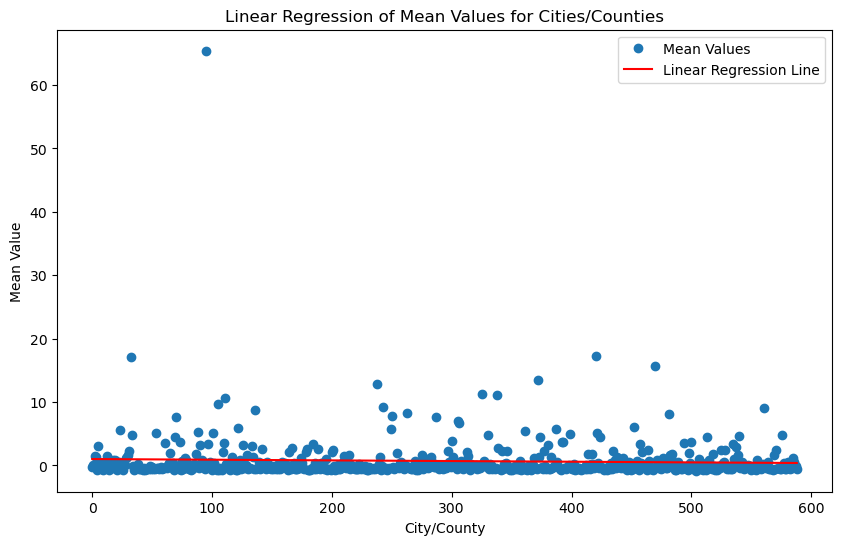

In [ ]:
# Calculate the mean for each city_or_county
mean_values = filtered_cities.mean(axis=1)

# Fit a linear regression line to the mean values
slope, intercept, _, _, _ = linregress(np.arange(len(mean_values)), mean_values)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot the mean values
plt.plot(np.arange(len(mean_values)), mean_values, marker='o', linestyle='', label='Mean Values')

# Plot the linear regression line
linear_regression_line = np.arange(len(mean_values)) * slope + intercept
plt.plot(np.arange(len(mean_values)), linear_regression_line, label='Linear Regression Line', color='red')

plt.legend()
plt.title('Linear Regression of Mean Values for Cities/Counties')
plt.xlabel('City/County')
plt.ylabel('Mean Value')
plt.show()

### Removing Trends

In [ ]:
time_series_info = time_series_analysed.groupby('city_or_county').count()
print(time_series_info)

                iso_year  iso_week  severity_score
city_or_county                                    
Abilene              209       209             209
Aiken                209       209             209
Akron                209       209             209
Albany               209       209             209
Albert Lea           209       209             209
...                  ...       ...             ...
Yonkers              209       209             209
York                 209       209             209
Youngstown           209       209             209
Ypsilanti            209       209             209
Yuma                 209       209             209

[589 rows x 3 columns]


We will use Augmented Dickey-Fuller test to check stationarity or non-stationarity of timeseries. We find all timeseries that are not stationary using a threshold of 0.05 on the returned p-value.

In [ ]:
import warnings
from tqdm import tqdm 
from statsmodels.tsa.stattools import adfuller

In [ ]:
non_stationary_idx_list = []
with warnings.catch_warnings(record=True):
    for col in tqdm(filtered_cities.columns):
        adf = adfuller(filtered_cities[col])
        pvalue = adf[1]
        if pvalue > 0.05:
            non_stationary_idx_list.append(col)

100%|██████████| 209/209 [00:00<00:00, 270.39it/s]


In [ ]:
len(non_stationary_idx_list)

0

This proves that our timeseries has no trends, being as expected all linear and parallel to the x-axis.

### Removing Noise

To find the best sliding window for the noise we used the mean of the **sums of absolute differences (SAD)** between the original timeseries and the smoothed one, then we resorted to the elbow method to choose the best window that 'doesn't smooth too much' the original timeseries.

In [ ]:
noise_windows = np.array(range(1,21))
mean_sad_dict = dict()
for window_size in tqdm(noise_windows):
    sum_abs_diff_users = list()
    for city in filtered_cities.columns:
        # Calculate SAD for each user
        sum_abs_diff_single_per_user = np.sum(np.abs(filtered_cities[city].rolling(window=window_size, center = True, min_periods = 1).mean() - filtered_cities[city]))
        sum_abs_diff_users.append(sum_abs_diff_single_per_user)
    
    # Average the SAD for all users to get final SAD score
    mean_sad_dict[window_size] = np.average(sum_abs_diff_users)

100%|██████████| 20/20 [00:00<00:00, 26.71it/s]


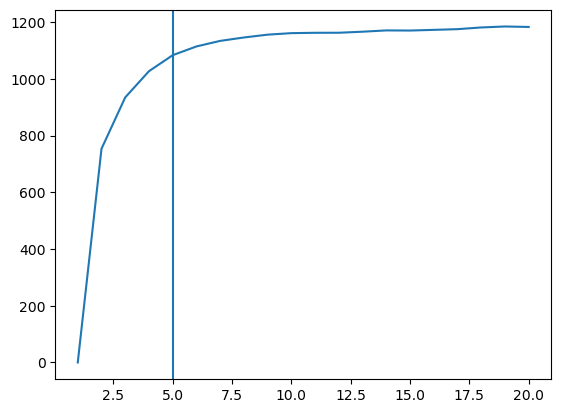

In [ ]:
plt.plot(mean_sad_dict.keys(), mean_sad_dict.values())
plt.axvline(5)
plt.show()

In [ ]:
window_size = 5

In [ ]:
# Function that denoises df of timeseries given a window size
def denoiser(df, window_size):
    denoised_df = df.apply(lambda ts : ts.rolling(window=window_size, center = True, min_periods = 1).mean())
    return denoised_df

In [ ]:
filtered_cities_denoised = denoiser(filtered_cities, window_size=window_size)

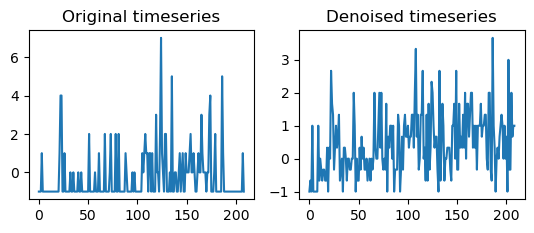

In [ ]:
ts_example = filtered_cities.loc['Abilene']
ts_example_denoised = filtered_cities_denoised.loc['Abilene']

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3/4)

ax2.plot(ts_example_denoised.to_numpy())
ax2.set_title('Denoised timeseries')
ax2.set_box_aspect(3/4)


plt.show()

### Scaler with mean and std

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [ ]:
filtered_cities_std = pd.DataFrame(columns=filtered_cities_denoised.columns)
scaler = TimeSeriesScalerMeanVariance(mu=0, std=1)  
for col in filtered_cities_denoised.columns:
    filtered_cities_std[col] = scaler.fit_transform(filtered_cities_denoised[col].values.reshape(1, -1)).flatten()

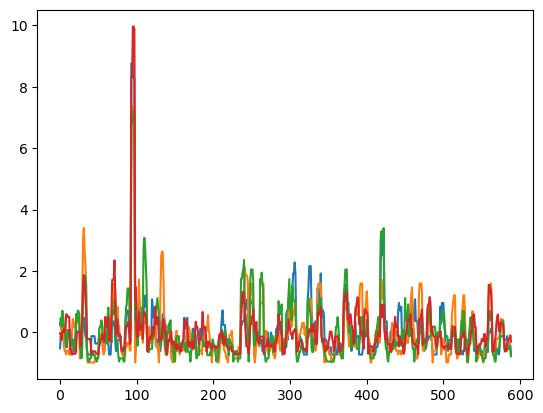

In [ ]:
ts_example_1 = filtered_cities_std.iloc[:, 16]
ts_example_2 = filtered_cities_std.iloc[:, 96]
ts_example_3 = filtered_cities_std.iloc[:, 104]
ts_example_4 = filtered_cities_std.iloc[:, 128]
plt.plot(ts_example_1.to_numpy())
plt.plot(ts_example_2.to_numpy())
plt.plot(ts_example_3.to_numpy())
plt.plot(ts_example_4.to_numpy())
plt.show()

In [ ]:
timeseries_data = np.transpose(filtered_cities_std.values)

## Clustering timeseries

In [ ]:
def print_clusters(y, K, model):
    print("k = ", K, "| Clusters =", np.unique(y,return_counts=True)[1], "| Inertia =", model.inertia_)

In [ ]:
def plot_timeseries_per_cluster(labels, n_clusters):
    fig, ax = plt.subplots(math.ceil(n_clusters/2), 2)
    print(np.shape(ax))
    colors = plt.rcParams["axes.prop_cycle"]()
    fig.set_size_inches(8, 8)

    max_num_samples_per_cluster = 5
    for c in range(n_clusters):
        cluster_index = [i for i, x in enumerate(labels) if x == c] 
        random_indexes = np.random.choice(
            cluster_index, size=min(len(cluster_index), max_num_samples_per_cluster), replace=False)
        cluster_sample = timeseries_data[random_indexes]
        
        ax_idx_row = math.ceil(c/2)-1
        ax_idx_col = c % 2
        ax_c = ax[ax_idx_row][ax_idx_col]
        color = next(colors)["color"]
        ax_c.set_title('Cluster: '+str(c), y=1.0, pad=-14)
        for ts in cluster_sample:
            ax_c.plot(ts, color=color)

    plt.show()

In [ ]:
dict_colors_bot = { 1: 'teal', 0: 'sandybrown'}

# def plot_is_killed_pieplots(labels, n_clusters):
#      for k in range(n_clusters):
#         # Get 'bot' values for elems in cluster k
#         bot_for_cluster = result_df.loc[labels == k].value_counts()
#         # Show pie plot
#         plt.title('Cluster: ' + str(k))
#         plt.pie(bot_for_cluster, labels= bot_for_cluster.index, colors=[dict_colors_bot[v] for v in bot_for_cluster.reset_index()['bot'].to_numpy()])
#         plt.show()
#         print(bot_for_cluster)

def plot_is_killed_pieplots(labels, n_clusters):
    for k in range(n_clusters):
        # Get indices of rows in cluster k
        cluster_indices = np.where(labels == k)[0]
        # Extract the corresponding rows from result_df
        cluster_df = result_df.iloc[cluster_indices]
        # Get 'bot' values for elems in cluster k
        bot_for_cluster = cluster_df['isKilled'].value_counts()
        
        # Show pie plot
        plt.title('Cluster: ' + str(k))
        plt.pie(bot_for_cluster, labels=bot_for_cluster.index, colors=[dict_colors_bot[v] for v in bot_for_cluster.index])
        plt.show()
        
        print(bot_for_cluster)

### Shape-Based clustering
#### K-Means

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
with warnings.catch_warnings(record=True):
    # Define lists of the K values for euclidean kmeans
    inertia_euclidean = list()
    models_euclidean = list()

    metric = 'euclidean'
    print("Clusters sizes for each K with", metric, "metric:")

    for n_clusters in range(2, 21):
        # Build and fit Kmeans
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, max_iter=10)
        model.fit(timeseries_data)
        y = model.predict(timeseries_data)
        # Print cluster and inertia info
        print_clusters(y, n_clusters, model)

        inertia_euclidean.append(model.inertia_)
        models_euclidean.append(model)

Clusters sizes for each K with euclidean metric:
k =  2 | Clusters = [152  57] | Inertia = 154.9782295537218
k =  3 | Clusters = [59 59 91] | Inertia = 151.09482701613484
k =  4 | Clusters = [16 64 38 91] | Inertia = 145.86635794129165


k =  5 | Clusters = [ 8 86 16 71 28] | Inertia = 143.9853114076966
k =  6 | Clusters = [31 12 40 81 20 25] | Inertia = 143.74432103119858
k =  7 | Clusters = [ 6 31 24 31  4 17 96] | Inertia = 142.42730097711137
k =  8 | Clusters = [26 11 23 40 16 21 17 55] | Inertia = 139.61497868348866
k =  9 | Clusters = [ 18   7   5 101  20  26   4  26   2] | Inertia = 138.599808021976
k =  10 | Clusters = [ 3 14 19 30  6 18 26  8 12 73] | Inertia = 137.05447328363869
k =  11 | Clusters = [ 3 23  4  1 47 57  1 43 10  5 15] | Inertia = 137.2921094995126
k =  12 | Clusters = [ 1 32  6 44 18 38  1  8 23 35  2  1] | Inertia = 134.30775263295115
k =  13 | Clusters = [ 6  5 27 24 46  4  9 11 38  1 17 20  1] | Inertia = 132.59581810717827
k =  14 | Clusters = [ 7 31 22 15 19  1  1 10 16 48  1 22  9  7] | Inertia = 132.21413587490875
k =  15 | Clusters = [ 3 23  5 42 12 19 14  3 12 25  1  2 30  1 17] | Inertia = 132.65030555925398
k =  16 | Clusters = [19 12 55 21  3  4  4 10 30  1  2  1 10 22 14  1] | Ine

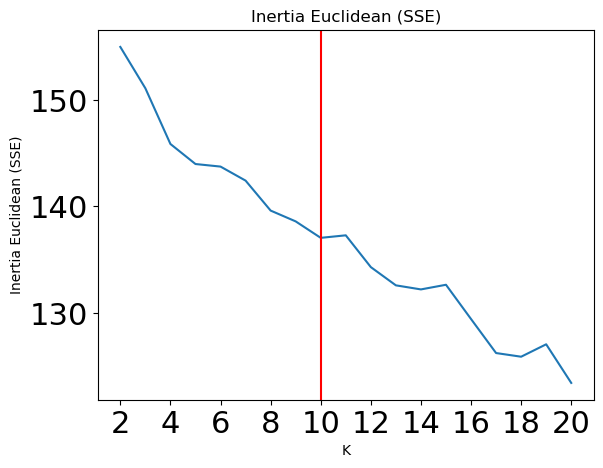

In [ ]:
plt.plot(range(2, len(inertia_euclidean) + 2), inertia_euclidean)
plt.ylabel('Inertia Euclidean (SSE)')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(np.arange(2,21,2))
plt.title('Inertia Euclidean (SSE)')
plt.axvline(10, color='r')
plt.show()

In [ ]:
euclidean_n_clusters = 10
euclidean_kmeans = models_euclidean[euclidean_n_clusters-2]

(5, 2)


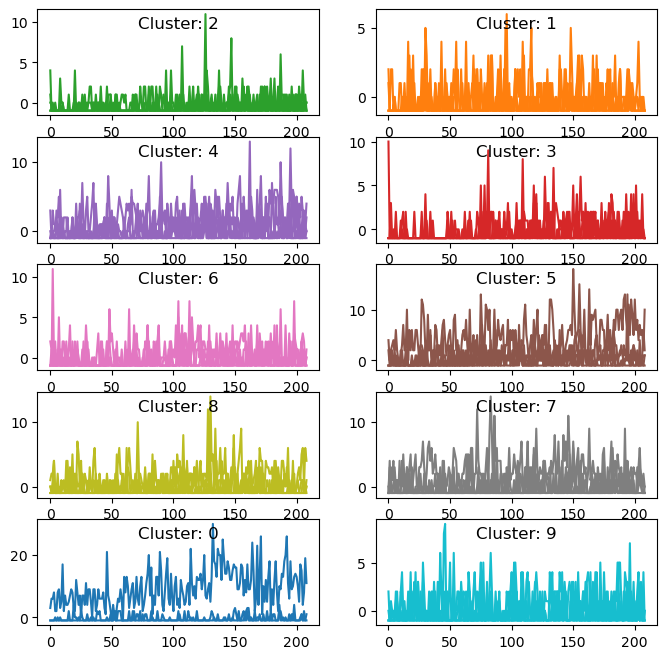

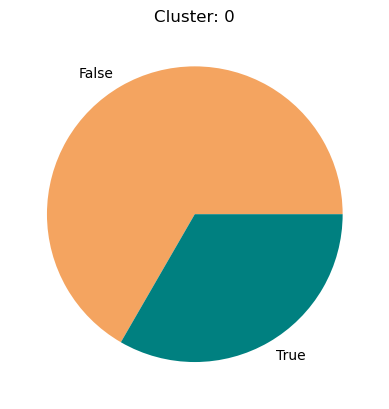

isKilled
False    2
True     1
Name: count, dtype: int64


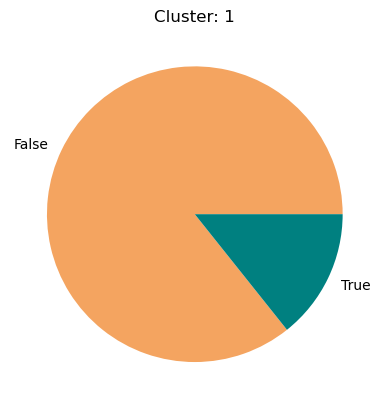

isKilled
False    12
True      2
Name: count, dtype: int64


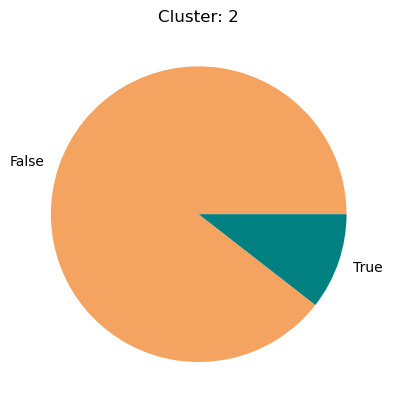

isKilled
False    17
True      2
Name: count, dtype: int64


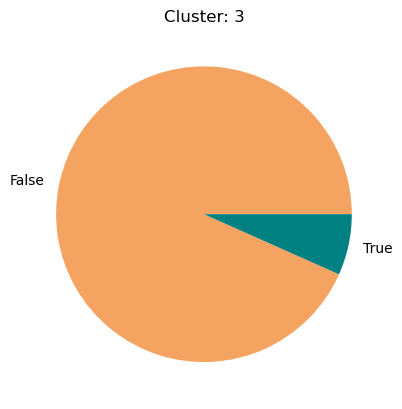

isKilled
False    28
True      2
Name: count, dtype: int64


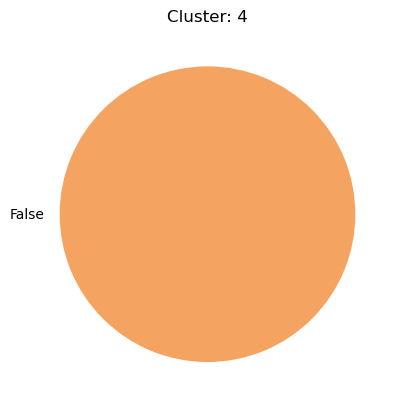

isKilled
False    6
Name: count, dtype: int64


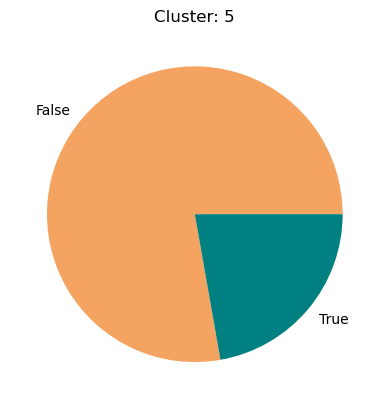

isKilled
False    14
True      4
Name: count, dtype: int64


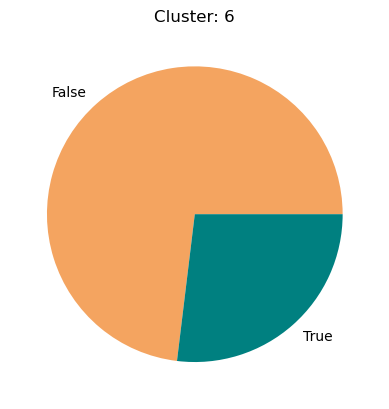

isKilled
False    19
True      7
Name: count, dtype: int64


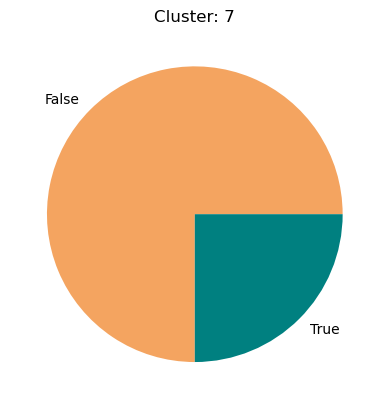

isKilled
False    6
True     2
Name: count, dtype: int64


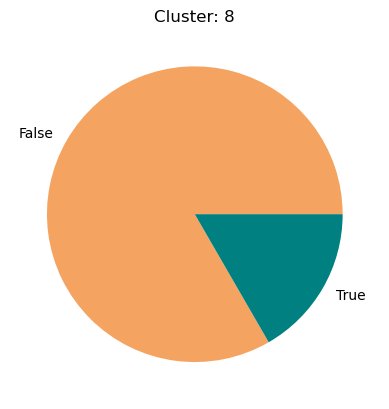

isKilled
False    10
True      2
Name: count, dtype: int64


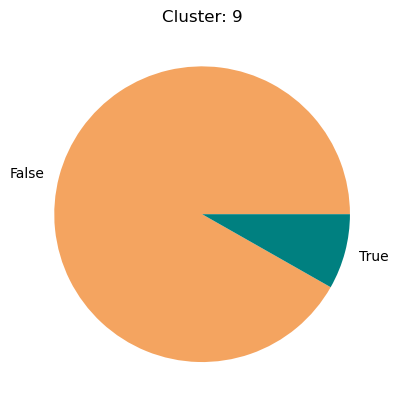

isKilled
False    67
True      6
Name: count, dtype: int64


In [ ]:
plot_timeseries_per_cluster(euclidean_kmeans.labels_, euclidean_n_clusters)
plot_is_killed_pieplots(euclidean_kmeans.labels_, euclidean_n_clusters)

#### Dynamic Time Warping

In [ ]:
metric = 'dtw'
dtw_n_clusters = 10

In [ ]:
model = TimeSeriesKMeans(n_clusters=dtw_n_clusters, metric=metric, max_iter=10)
model.fit(timeseries_data)
y = model.predict(timeseries_data)
# Print cluster and inertia info
print("Clustering info for KMeans with", metric, "metric")
print_clusters(y, 10, model)

inertia_dtw = model.inertia_
model_dtw = model

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 209 1-dimensional timeseries
  warnings.warn(


Clustering info for KMeans with dtw metric
k =  10 | Clusters = [15 17 25 11 17  9 19 20 68  8] | Inertia = 56.09696209992105


(5, 2)


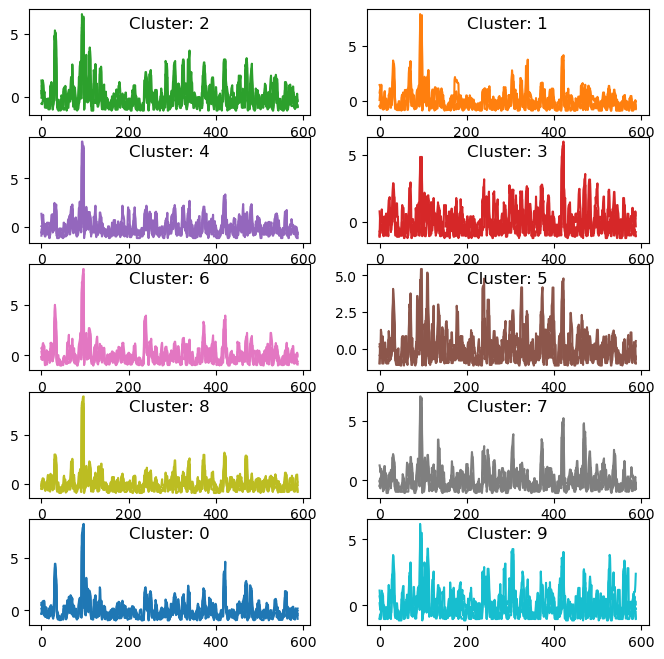

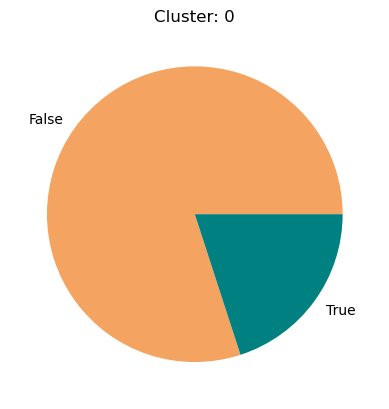

isKilled
False    12
True      3
Name: count, dtype: int64


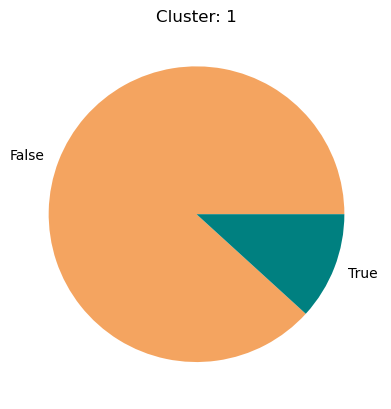

isKilled
False    15
True      2
Name: count, dtype: int64


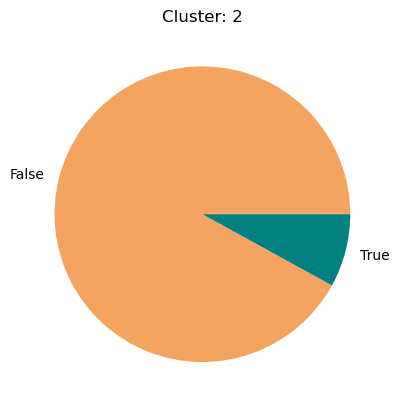

isKilled
False    23
True      2
Name: count, dtype: int64


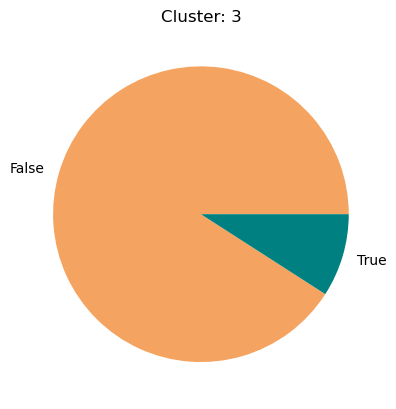

isKilled
False    10
True      1
Name: count, dtype: int64


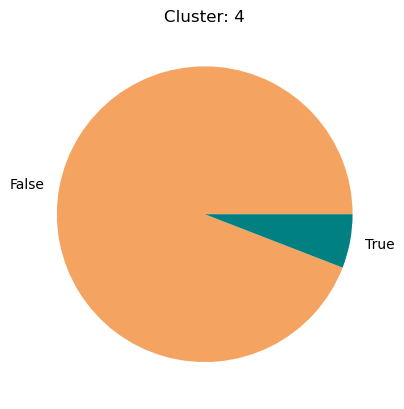

isKilled
False    16
True      1
Name: count, dtype: int64


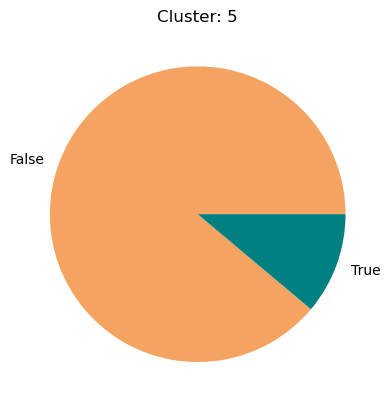

isKilled
False    8
True     1
Name: count, dtype: int64


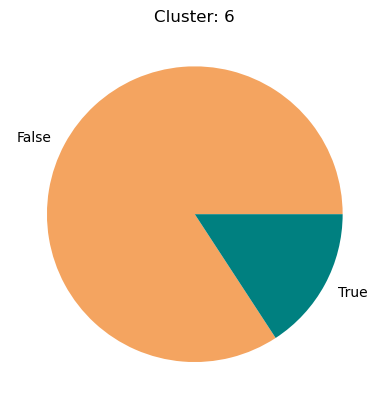

isKilled
False    16
True      3
Name: count, dtype: int64


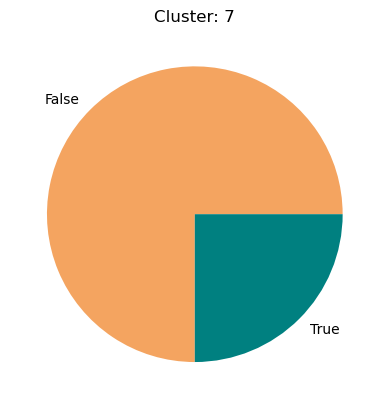

isKilled
False    15
True      5
Name: count, dtype: int64


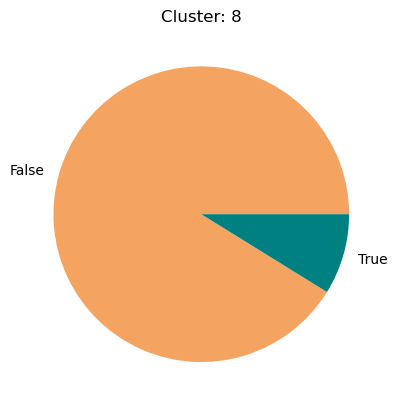

isKilled
False    62
True      6
Name: count, dtype: int64


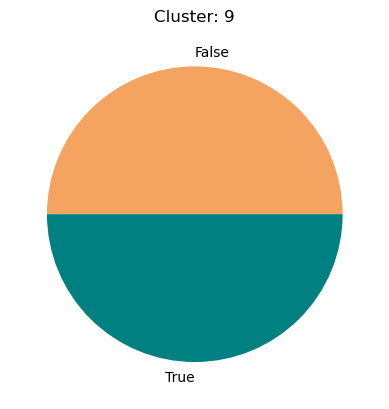

isKilled
False    4
True     4
Name: count, dtype: int64


In [ ]:
plot_timeseries_per_cluster(model_dtw.labels_, dtw_n_clusters)
plot_is_killed_pieplots(model_dtw.labels_, dtw_n_clusters)

### Feature based clustering

In [ ]:
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
def calculate_features(values):
    # Define a set of features to extract from the timeseries
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }
    return features

Extract features from timeseries

In [ ]:
timeseries_features = [list(calculate_features(x).values())[:-2] for x in timeseries_data]

#### K-Means

Use minmax normalization for KMeans.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(timeseries_features)

In [ ]:
def KMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=300):
    kmeans_list = list()
    for numCluster in tqdm(n_clusters_list):
        # Define and fit K-Means
        kmeans = KMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value)
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    return kmeans_list

In [ ]:
# Params for kmeans
clusters_list = [x for x in range(2, 20)]
init_value = 10
iter_value = 300
# Get list of kmeans with from the list of possible k
kmeans_list = KMeansFunction (X_minmax, clusters_list, init_value, iter_value)
# Calculate SSE for each kmeans
sse_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    print_clusters(kmeans.labels_, clusters_list[i], kmeans)

  0%|          | 0/18 [00:00<?, ?it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7b91d1d940>
Traceback (most recent call last):
  File "/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/threadpoolctl.py", line 605, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/ctypes/__init__

k =  2 | Clusters = [130  79] | Inertia = 31.468209463592864
k =  3 | Clusters = [58 85 66] | Inertia = 23.67212228871152
k =  4 | Clusters = [61 54 37 57] | Inertia = 19.840851737007632
k =  5 | Clusters = [32 54 31 51 41] | Inertia = 17.085808216269797
k =  6 | Clusters = [48 57 28 43 26  7] | Inertia = 15.533237170574452
k =  7 | Clusters = [11 20 40 19 60 34 25] | Inertia = 14.081471351282335
k =  8 | Clusters = [33 11 51 31  9 29 15 30] | Inertia = 13.088010568365076
k =  9 | Clusters = [31 25  8 26 30  9 24 41 15] | Inertia = 12.115592765434469
k =  10 | Clusters = [27  9 38 24 26 11 28  8 13 25] | Inertia = 11.448791543937071
k =  11 | Clusters = [35 19 20 15 21 23 12 17 21  9 17] | Inertia = 10.743666381046557
k =  12 | Clusters = [25 21 18 15 23 22 29  6 15  7 11 17] | Inertia = 10.353075215458688
k =  13 | Clusters = [ 7 17 21 21  7 19 26  8 20 28  6 15 14] | Inertia = 9.893324052868632
k =  14 | Clusters = [20 13 23 10 25 20 27  4  8  8 15  7 25  4] | Inertia = 9.51280233248

Now we plot the SSE curve to help the choice of the best K.

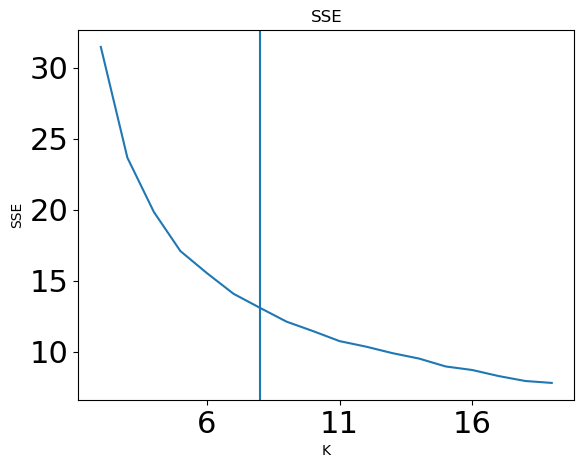

In [ ]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.axvline(8)
plt.show()

In this case we choose K = 8 as we can deduct from the knee method.

In [ ]:
best_n_clusters = 8
best_kmeans = kmeans_list[best_n_clusters-2]

Now we show the timeseries for each cluster

(4, 2)


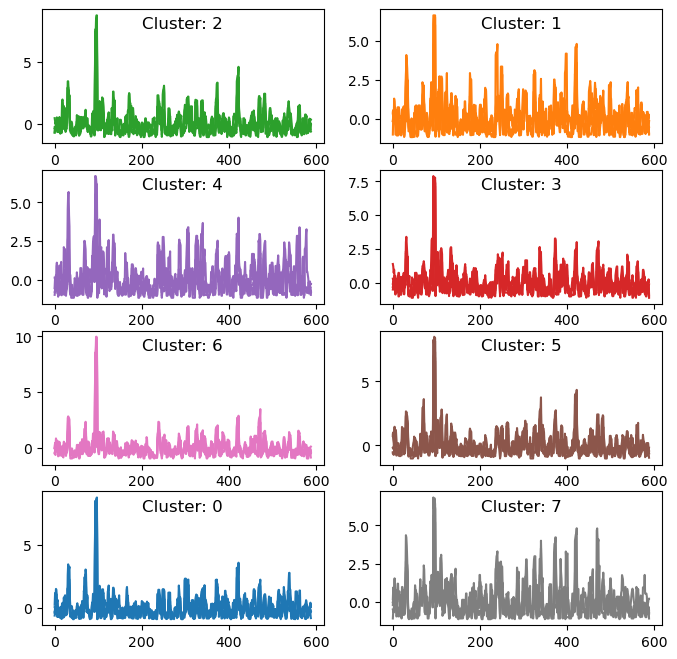

In [ ]:
plot_timeseries_per_cluster(best_kmeans.labels_, best_n_clusters)

Feature based KMeans clustering seems to work well on the timeseries, clustering with good precision the ones with spikes in the same positions. It seems that it also separates in specific clusters the timeseries having negative spikes, such as cluster 3 and 1.

#### Hierachical

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fclusterdata

Use both Z-score and minmax normalization.

In [ ]:
from sklearn.discriminant_analysis import StandardScaler

In [ ]:
scaler = StandardScaler()
X_std = scaler.fit_transform(timeseries_features)

In [ ]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(timeseries_features)

##### With minmax normalization


In [ ]:
config_hierarchical_minmax = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

Method: complete, threshold: 0.35, n_clusters: 3

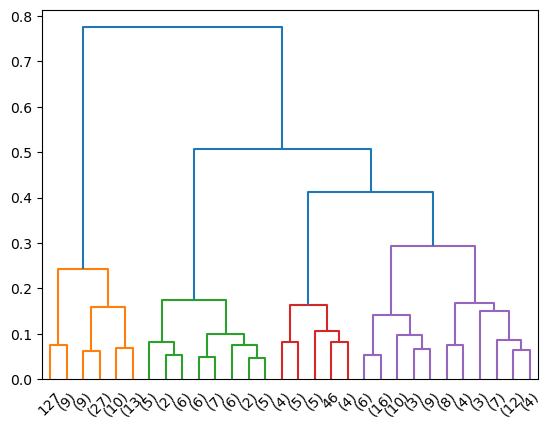

In [ ]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
res = dendrogram(data_link, color_threshold=0.35, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minmax.append((0.35, 'cosine', 'complete'))

method: ward, threshold: 2.0, n_clusters: 3

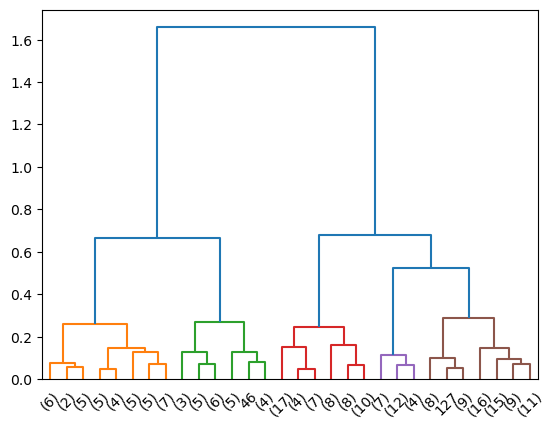

In [ ]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=0.3, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minmax.append((2.0, 'cosine', 'ward'))

method: average, threshold: 0.1, n_clusters: 3

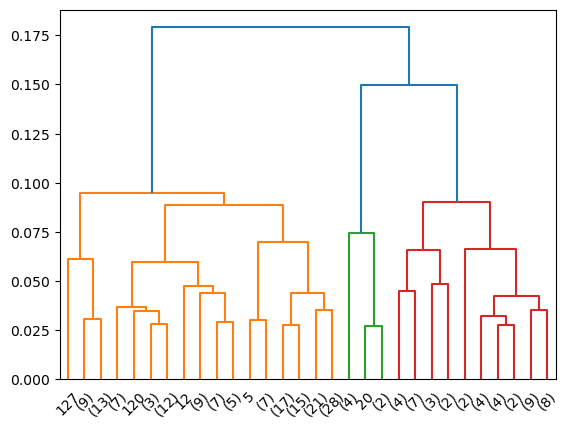

In [ ]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.1, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minmax.append((0.1, 'cosine', 'average'))

method: centroid, threshold: 0.1, n_clusters: 3

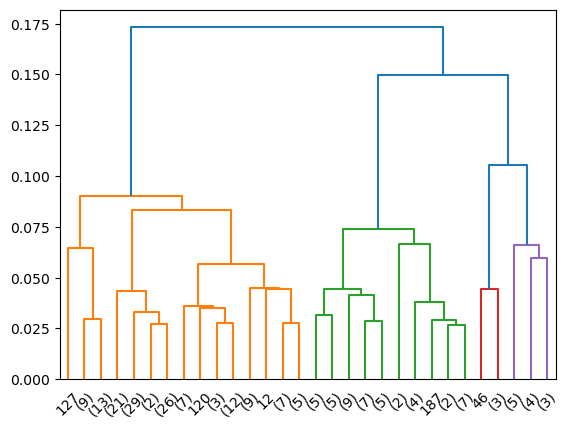

In [ ]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.1, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minmax.append((0.1, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [ ]:
cluster_list_minmax = []
for treshold, metric_minmax, method_minmax in config_hierarchical_minmax:
    cluster = fclusterdata(X=X_minmax,
     t=treshold , criterion='distance', metric=metric_minmax, method=method_minmax)
    cluster_list_minmax.append(cluster)

Calculate Silhouette for each clustering.

In [ ]:
for i, clustering in enumerate(cluster_list_minmax):
    threshold, metric, method = config_hierarchical_minmax[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_minmax, clustering)
    except:
        silhouette = np.nan
    print("MINMAX - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('')

MINMAX - dist: cosine , method: complete , SILHOUTTE: 0.19499511081270884 , n_clusters: 4
Clusters Size: [69, 39, 19, 82]

MINMAX - dist: cosine , method: ward , SILHOUTTE: nan , n_clusters: 1
Clusters Size: [209]

MINMAX - dist: cosine , method: average , SILHOUTTE: 0.28875888371920394 , n_clusters: 3
Clusters Size: [157, 7, 45]

MINMAX - dist: cosine , method: centroid , SILHOUTTE: 0.2533835231066305 , n_clusters: 4
Clusters Size: [146, 47, 4, 12]



##### With mean-std normalization


In [ ]:
config_hierarchical_std = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

method: complete, threshold: 1.65, n_clusters: 9

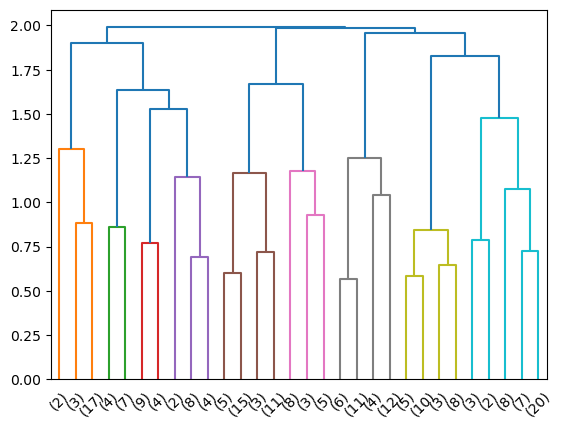

In [ ]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
res = dendrogram(data_link, color_threshold=1.48, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((1.48, 'cosine', 'complete'))

method: ward, threshold: 2.8, n_clusters: 8

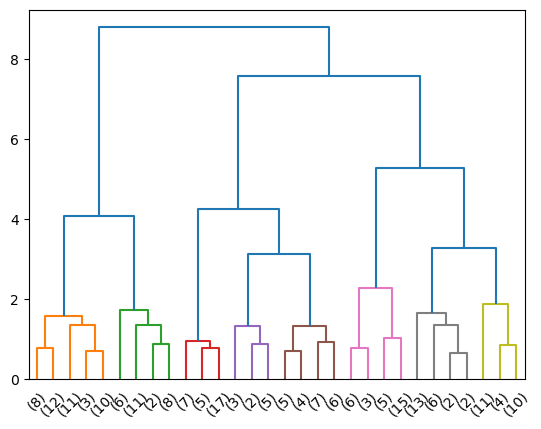

In [ ]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=2.8, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((2.8, 'cosine', 'ward'))

method: average, threshold: 0.72, n_clusters: 6

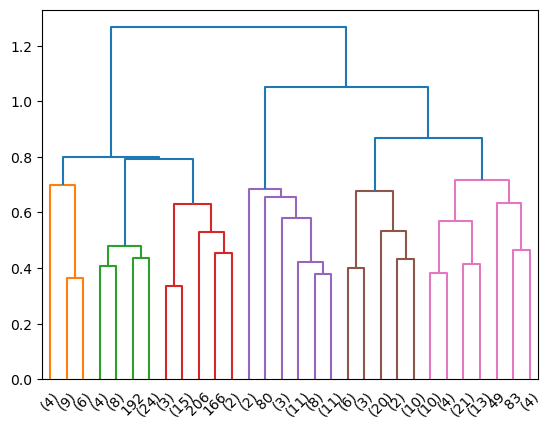

In [ ]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.72, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.72, 'cosine', 'average'))

method: centroid, threshold: 0.6, n_clusters: 8

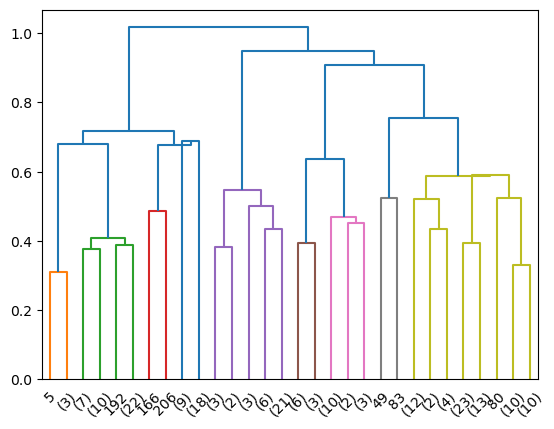

In [ ]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.6, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.6, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [ ]:
cluster_list_std = []
for treshold, metric_std, method_std in config_hierarchical_std:
    cluster = fclusterdata(X=X_std,
     t=treshold , criterion='distance', metric=metric_std, method=method_std)
     
    cluster_list_std.append(cluster)

Calculate Silhouette for each clustering.

In [ ]:
for i, clustering in enumerate(cluster_list_std):
    treshold, metric, method = config_hierarchical_std[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_std, clustering)
    except:
        silhouette = np.nan
    print("STD - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('')

STD - dist: cosine , method: complete , SILHOUTTE: 0.09353026888949435 , n_clusters: 9
Clusters Size: [22, 11, 13, 14, 34, 16, 33, 26, 40]

STD - dist: cosine , method: ward , SILHOUTTE: 0.14913979864566765 , n_clusters: 8
Clusters Size: [44, 27, 29, 10, 22, 29, 23, 25]

STD - dist: cosine , method: average , SILHOUTTE: 0.16567760906758575 , n_clusters: 6
Clusters Size: [19, 37, 22, 36, 41, 54]

STD - dist: cosine , method: centroid , SILHOUTTE: 0.022946980154219015 , n_clusters: 10
Clusters Size: [4, 40, 2, 9, 18, 35, 9, 15, 2, 75]



The final chosen hierarchical cluster selected is the one with **ward** method and **std** normalization, as it has an appropriate number of clusters and elements for each clusters, a dendrogram with well distanciated branches and relatively higher Silhouette for its number of clusters.

In [ ]:
best_hierarchical = np.array(cluster_list_std[2]) - 1
best_n_clusters = len(np.unique(best_hierarchical))

We plot the timeseries for the hierarchical clustering with with **ward** method and **std** normalization.

(3, 2)


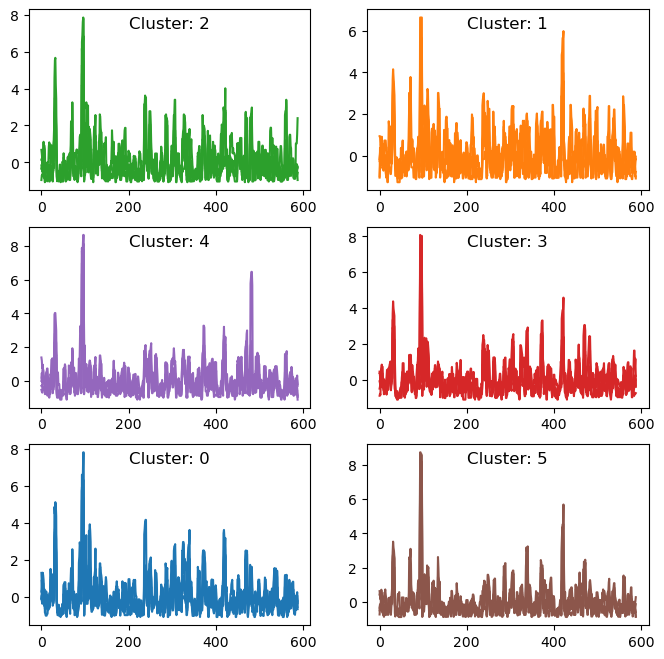

In [ ]:
plot_timeseries_per_cluster(best_hierarchical, best_n_clusters)

Hierarchical seems to have clusters which have less coincidence in the positions of spikes, compared to KMeans.

### Compression based clustering

In [ ]:
from tslearn.piecewise import PiecewiseAggregateApproximation

We use PAA as the compression.

In [ ]:
n_paa_segments = 27
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(timeseries_data)

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 209 1-dimensional timeseries
  warnings.warn(


Show PAA transformed timeseries

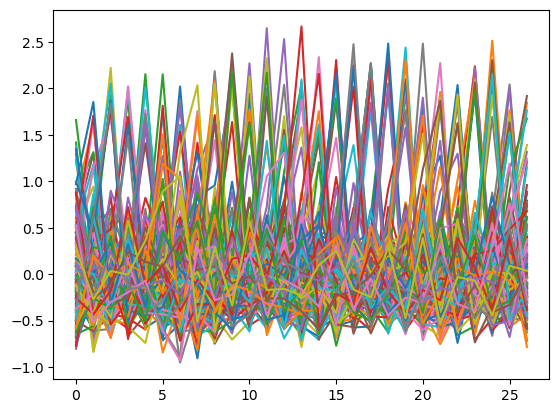

In [ ]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [ ]:
def TSKMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=5):
    kmeans_list = list()

    for numCluster in tqdm(n_clusters_list):
        # Define and fit K-Means
        kmeans = TimeSeriesKMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value, random_state=0, metric='euclidean')
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

In [ ]:
# Params for kmeans
clusters_list = [x for x in range(2, 21)]
init_value = 5
iter_value = 10

# Get list of kmeans with from the list of possible k
kmeans_list = TSKMeansFunction (X_minmax, clusters_list, init_value, iter_value)

# Calculate SSE for each kmeans
sse_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    print_clusters(kmeans.labels_, clusters_list[i], kmeans)

100%|██████████| 19/19 [00:04<00:00,  4.23it/s]

k =  2 | Clusters = [ 75 134] | Inertia = 0.150579732584329
k =  3 | Clusters = [71 89 49] | Inertia = 0.11342724777413382
k =  4 | Clusters = [36 59 54 60] | Inertia = 0.09487605167490476
k =  5 | Clusters = [38 42 28 55 46] | Inertia = 0.08194051332590083
k =  6 | Clusters = [48 43 17 31 11 59] | Inertia = 0.07335516906152426
k =  7 | Clusters = [21 48 45 22 22 39 12] | Inertia = 0.06786706555168281
k =  8 | Clusters = [42 16 29 29 37 19  7 30] | Inertia = 0.06331282135780769
k =  9 | Clusters = [28 25 26 24 18 15 44  8 21] | Inertia = 0.05806460750982386
k =  10 | Clusters = [26 14 25 20 15 27 19 35  6 22] | Inertia = 0.055351862565168525
k =  11 | Clusters = [14 25  7 22 20 23  8 21 28 12 29] | Inertia = 0.051990026397064446
k =  12 | Clusters = [26 12 24 15 18 28 19 30  6 19  5  7] | Inertia = 0.04986966648838331
k =  13 | Clusters = [26 12 19 12 16 25 19 30  6 19  5  6 14] | Inertia = 0.0473757604305328
k =  14 | Clusters = [26 12 19 11 16 22 19 27  5 20  5  6 14  7] | Inertia = 

Now we plot the SSE curve to help the choice of the best K.

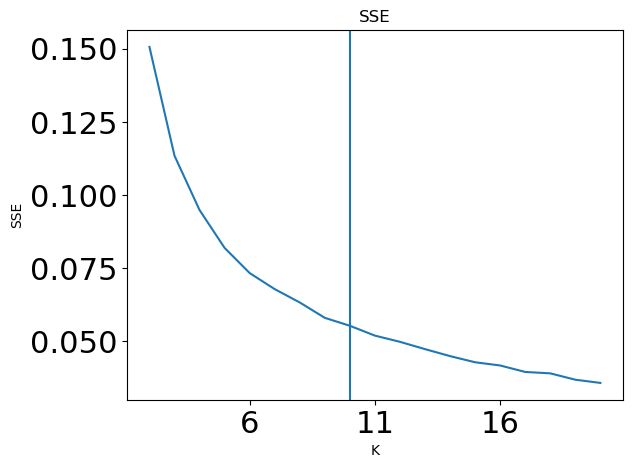

In [ ]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.axvline(10)
plt.show()

The best K according to the SSE knee method is K=10

In [ ]:
best_n_clusters = 10
best_kmeans = kmeans_list[best_n_clusters-2]

Now we show the timeseries for each cluster

(5, 2)


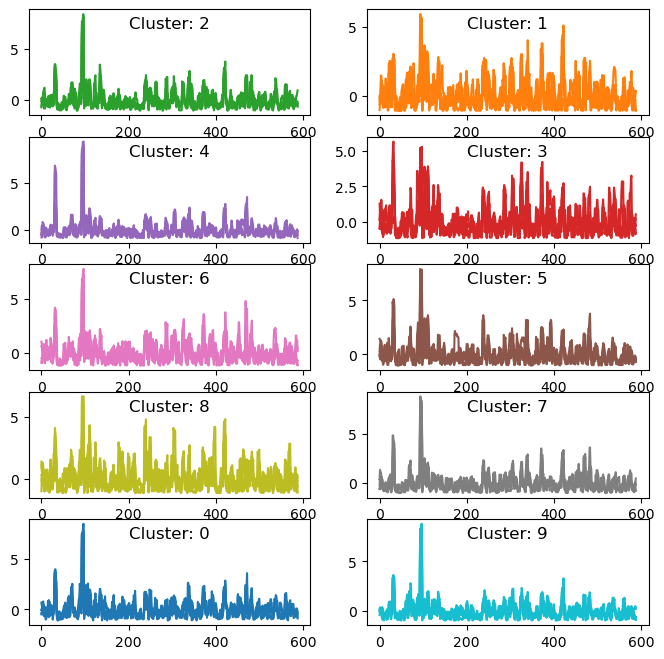

In [ ]:
plot_timeseries_per_cluster(best_kmeans.labels_, best_n_clusters)

Clustering is similar to the one obtained with shape clustering, but some clusters (such as 4 and 3) seems to have less recognizable common patterns for the timeseries.

Show cluster centers for each cluster of the compressed timeseries next to the cluster means of the original timeseries.

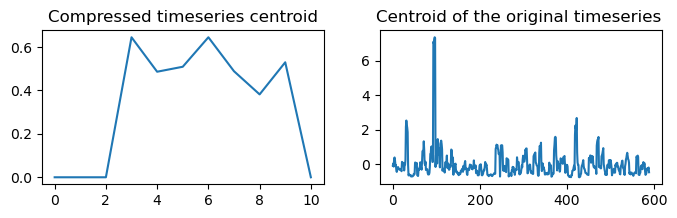

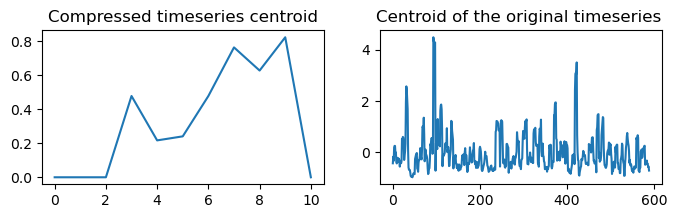

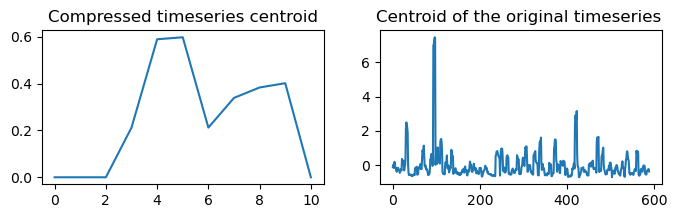

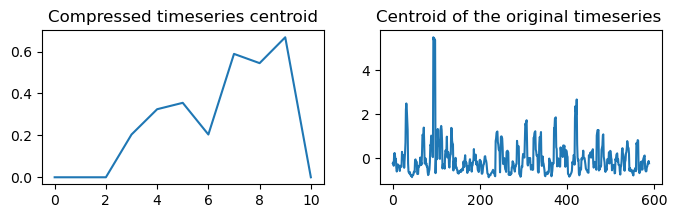

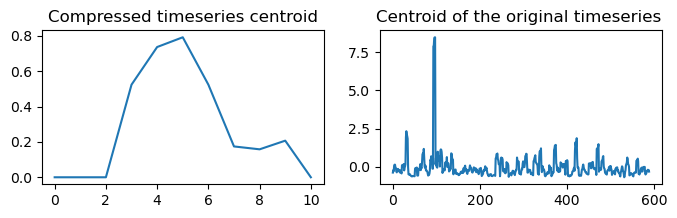

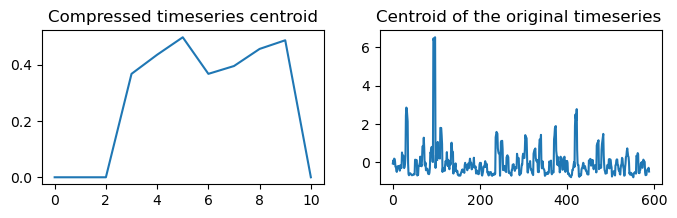

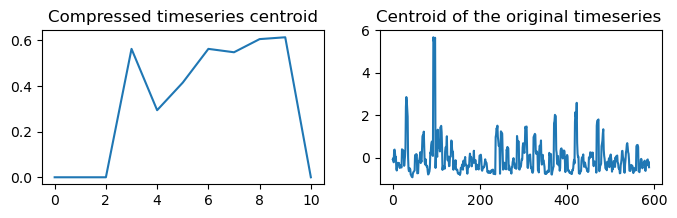

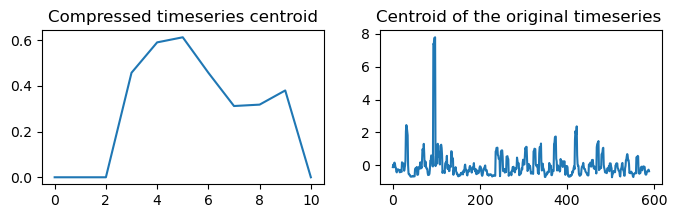

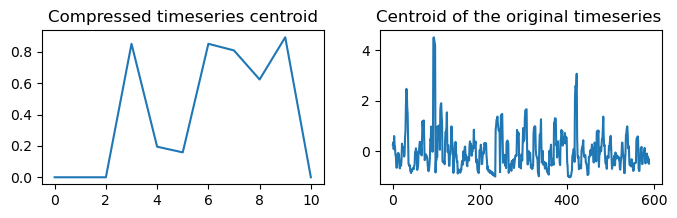

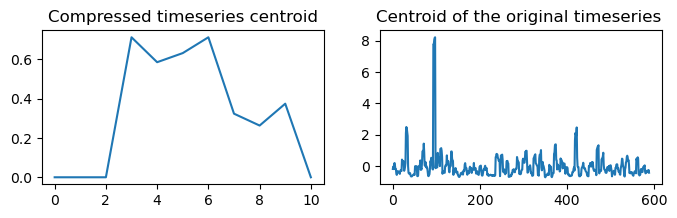

In [ ]:
for c in range(best_n_clusters):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(best_kmeans.cluster_centers_[c])#.reshape(X_paa.shape[1], best_n_clusters))
    ax1.set_title("Compressed timeseries centroid")

    ax2.plot(np.mean(timeseries_data[np.where(best_kmeans.labels_ == c)], axis=0))
    ax2.set_title("Centroid of the original timeseries ")
    
    fig.set_size_inches(8, 2)
    plt.show()

It seems there is not much correspondance between PAA timeseries centroid and average cluster of the original timeseries.

### Clustering Conclusions

Of the methods used for clustering, the one which, subjected to further analysis, produced the best results was the Shape-Based K-Means with Euclidean metric.

## Shapelets

In [ ]:
# from tensorflow.keras.optimizers import Adagrad
# from tslearn.shapelets import LearningShapelets
# from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
# from tslearn.preprocessing import TimeSeriesScalerMinMax
# import tensorflow as tf
# from sklearn.model_selection import train_test_split

In [ ]:
# timeseries_data = np.transpose(filtered_cities_std.values)

In [ ]:
# labels = filtered_incidents_is_killed.values

In [ ]:
# plt.figure()
# for i, single_class in enumerate(['not_killed', 'killed']):
#     plt.subplot(2, 1, i + 1)
#     mask = labels.T == i
#     for x in timeseries_data[mask[0]]:
#         plt.plot(x, color='C0', linewidth=0.9)
#     plt.title('Class: {}'.format(single_class), fontsize=16)
    
# plt.subplots_adjust(hspace=0.4)

# plt.show()

Train test split 0.25

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(timeseries_data, labels,
#  test_size=0.25, random_state=1000, stratify = labels)

In [ ]:
# print(X_train.shape)
# print(X_test.shape)

Use grabocka method to identify the number of shapelets for each shapelet size

In [ ]:
# n_ts, ts_sz = X_train.shape
# n_classes = 2

# shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
#                                                        ts_sz=ts_sz,
#                                                        n_classes=n_classes,
#                                                        l=0.06,
#                                                        r=1)

# print('n_ts', n_ts)
# print('ts_sz', ts_sz)
# print('n_classes', n_classes)
# print('shapelet_sizes', shapelet_sizes)

Build the shapelet model to extract shapelet. We use shapelet sizes and numbers from previous grabocka method.

In [ ]:
# shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
#                             optimizer=tf.optimizers.Adam(.01),
#                             batch_size=16,
#                             weight_regularizer=.005,
#                             max_iter=10,
#                             random_state=42,
#                             verbose=1)

Fit the shapelet model

In [ ]:
# shp_clf.fit(X_train, y_train)

Predict on test

In [ ]:
# y_pred_test = shp_clf.predict(X_test)
# predicted_locations = shp_clf.locate(X_test)

In [ ]:
# print(classification_report(y_test, y_pred_test))

Print all the shapelets

In [ ]:
# len(shp_clf.shapelets_as_time_series_)
# for i, shp in enumerate(shp_clf.shapelets_as_time_series_):
#     plt.figure(figsize=(2,1))
#     plt.title(f"SHAPELET: {i}")
#     plt.plot(shp)
#     plt.show()

In [ ]:
# ts_id = 1
# plt.figure(figsize=(21.,3.))
# n_shapelets = sum(shapelet_sizes.values())


# plt.plot(X_test[ts_id].ravel())
# count = 0
# for idx_shp, shp in enumerate(shp_clf.shapelets_):
#     t0 = predicted_locations[ts_id, idx_shp]
#     if t0 > 0:
#         plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
#         count+=1
# plt.title("Example locations of shapelet ({} shapelets matched)".format(count))

# plt.show()
# plt.figure(figsize=(21.,3.))
# plt.plot(X_test[ts_id].ravel())
# plt.show()


# Motifs and Shapelets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matrixprofile import *
# import stumpy

In [ ]:
# time_series_data = np.transpose(filtered_cities_std.values)
# timeseries_data = np.transpose(best_hierarchical)
# timeseries_data = filtered_cities.copy()
timeseries_data = filtered_cities.values
time_series_data

array([[-0.98107276, -0.50516117, -0.60034349, ..., -0.98107276,
        -0.98107276, -0.98107276],
       [-0.68935953, -0.76745477, -0.81431192, ..., -0.06459762,
        -0.29888334, -0.37697858],
       [-1.03740521,  0.3896038 ,  0.104202  , ..., -0.87431846,
        -0.83354678, -0.76559397],
       ...,
       [-0.10975661, -0.06516657, -0.25244474, ...,  0.17561965,
         0.06860356, -0.10975661],
       [ 0.05230701, -0.24289097, -0.42000976, ..., -0.06577218,
         0.199906  ,  0.44590432],
       [ 0.16170012, -0.1647671 , -0.36064743, ..., -0.36064743,
        -0.1647671 , -0.2735895 ]])

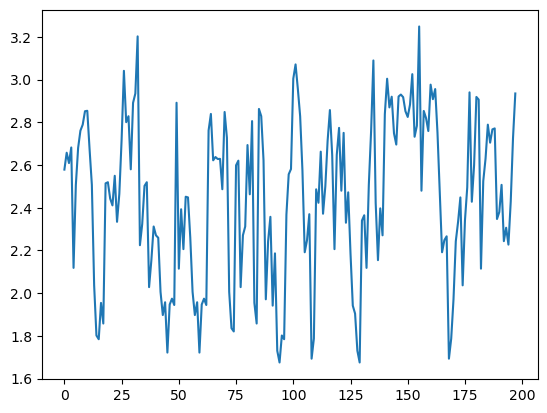

In [ ]:
w = 12
# profile = matrixProfile.stomp(time_series_data[:,16], w)
ts = time_series_data[:,16]
mp, mpi = matrixProfile.stomp(ts, w)

plt.plot(mp)
plt.show()

### Motif discovery
Parameters
- max_motifs: stop finding new motifs once we have max_motifs
- radius: For each motif found, find neighbors that are within radius*motif_mp of the first.
- n_neighbors: number of neighbors from the first to find. If it is None, find all.
- ex_zone: minimum distance between indices for after each subsequence is identified. Defaults to m/2 where m is the subsequence length. If ex_zone = 0, only the found index is exclude, if ex_zone = 1 then if idx is found as a motif idx-1, idx, idx+1 are excluded.


The function returns a tuple (top_motifs, distances) which are lists of the same length.

- top_motifs: This is a list of the indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances.
- distances: Minimum Matrix profile value for each motif set.

In [ ]:
mo, mod  = motifs.motifs(ts, (mp, mpi), max_motifs=5)

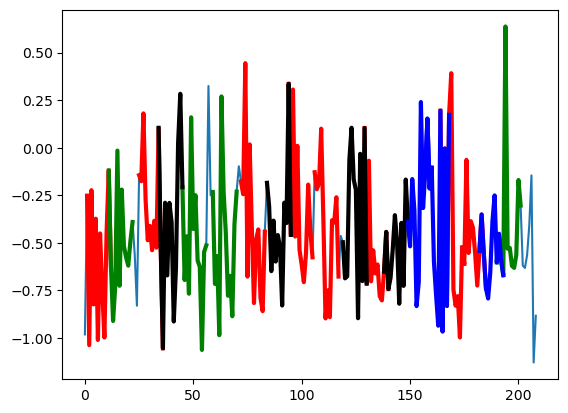

In [ ]:
plt.plot(ts)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

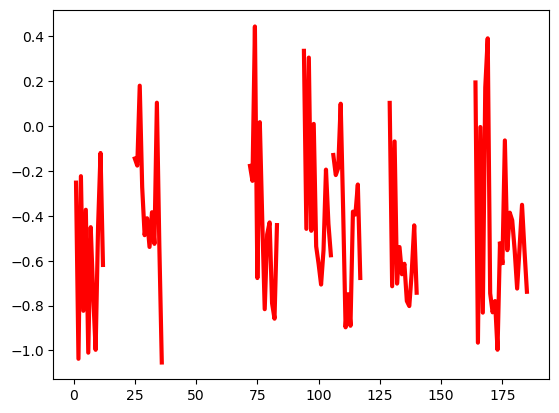

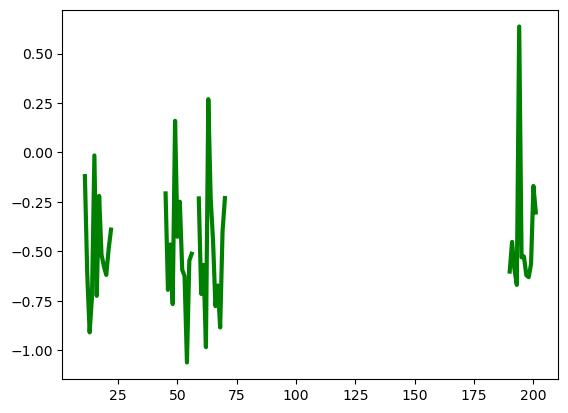

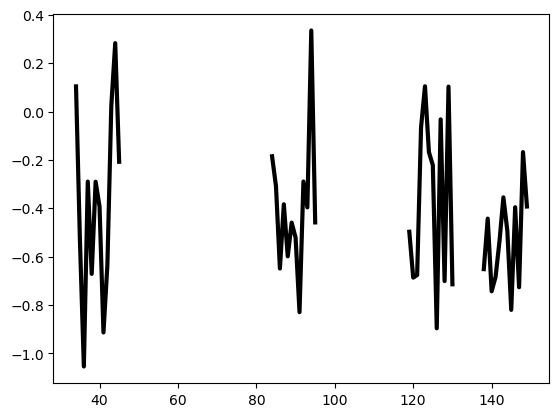

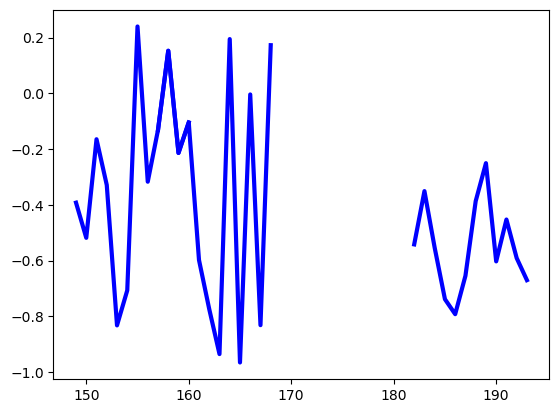

In [ ]:
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()

### Anomaly Discovery
Parameters  
- mp: matrix profile numpy array
- k: the number of discords to discover
- ex_zone: the number of samples to exclude and set to Inf on either side of a found discord   


Returns a list of indexes represent the discord starting locations. MaxInt indicates there were no more discords that could be found due to too many exclusions or profile being too small. Discord start indices are sorted by highest matrix profile value.

In [ ]:
from matrixprofile.discords import discords
anoms = discords(mp, ex_zone=3, k=5)

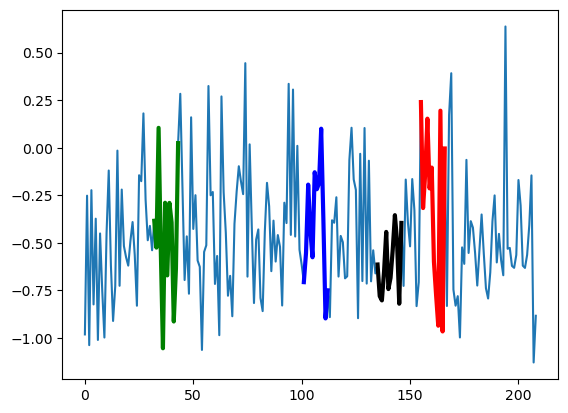

In [ ]:
plt.plot(ts)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = ts[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()

### Shaplet discovery

In [ ]:
from tensorflow.keras.optimizers import Adagrad
from tslearn.shapelets import LearningShapelets
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
labels = result_df.values

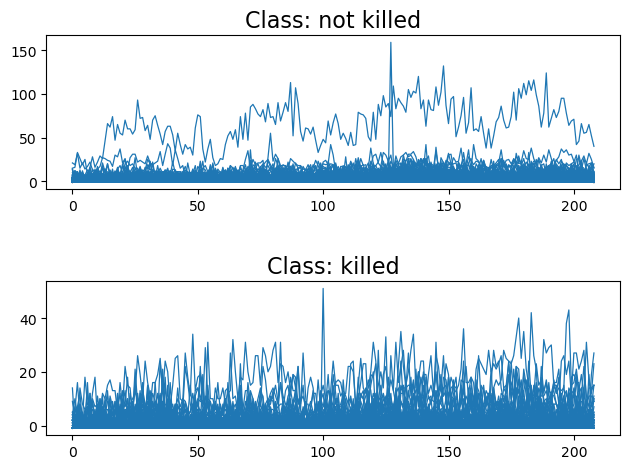

In [ ]:
plt.figure()
for i, classe in enumerate(['not killed', 'killed']):
    plt.subplot(2, 1, i + 1)
    mask = labels.T == i
    for x in timeseries_data[mask[0]]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.show()

Train test split 0.25

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(timeseries_data, labels,
 test_size=0.25, random_state=1000, stratify = labels)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(441, 209)
(148, 209)


Use grabocka method to identify the number of shapelets for each shapelet size

In [ ]:
n_ts, ts_sz = X_train.shape
n_classes = 2

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.06,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 441
ts_sz 209
n_classes 2
shapelet_sizes {12: 4}


Build the shapelet model to extract shapelet. We use shapelet sizes and numbers from previous grabocka method.

In [ ]:
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.005,
                            max_iter=10,
                            random_state=42,
                            verbose=1)

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Fit the shapelet model

In [ ]:
shp_clf.fit(X_train, y_train)

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/10
28/28 [==============================] - 1s 9ms/step - loss: 1564.5309 - binary_accuracy: 0.1519 - binary_crossentropy: 1564.5238
Epoch 2/10
28/28 [==============================] - 0s 5ms/step - loss: 536.6159 - binary_accuracy: 0.1519 - binary_crossentropy: 536.6106
Epoch 3/10
28/28 [==============================] - 0s 2ms/step - loss: 36.1695 - binary_accuracy: 0.8322 - binary_crossentropy: 36.1643
Epoch 4/10
28/28 [==============================] - 0s 4ms/step - loss: 22.7837 - binary_accuracy: 0.8345 - binary_crossentropy: 22.7789
Epoch 5/10
28/28 [==============================] - 0s 3ms/step - loss: 8.5763 - binary_accuracy: 0.6984 - binary_crossentropy: 8.5722
Epoch 6/10
28/28 [==============================] - 0s 2ms/step - loss: 7.6963 - binary_accuracy: 0.7302 - binary_crossentropy: 7.6929
Epoch 7/10
28/28 [==============================] - 0s 2ms/step - loss: 6.8779 - binary_accuracy: 0.7256 - binary_crossentropy: 6.8752
Epoch 8/10
28/28 [=======================

LearningShapelets(batch_size=16, max_iter=10, n_shapelets_per_size={12: 4},
                  optimizer=<keras.optimizers.adam.Adam object at 0x7f7a592ac7d0>,
                  random_state=42, verbose=1, weight_regularizer=0.005)

Predict on test

In [ ]:
y_pred_test = shp_clf.predict(X_test)
predicted_locations = shp_clf.locate(X_test)

10/10 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.85      0.78      0.81       125
        True       0.18      0.26      0.21        23

    accuracy                           0.70       148
   macro avg       0.51      0.52      0.51       148
weighted avg       0.75      0.70      0.72       148



Print all the shapelets

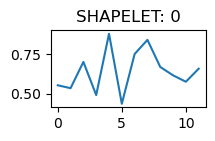

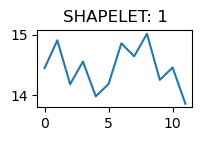

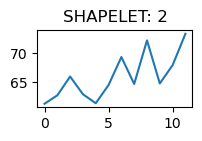

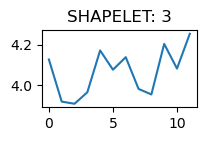

In [ ]:
len(shp_clf.shapelets_as_time_series_)
for i, shp in enumerate(shp_clf.shapelets_as_time_series_):
    plt.figure(figsize=(2,1))
    plt.title(f"SHAPELET: {i}")
    plt.plot(shp)
    plt.show()

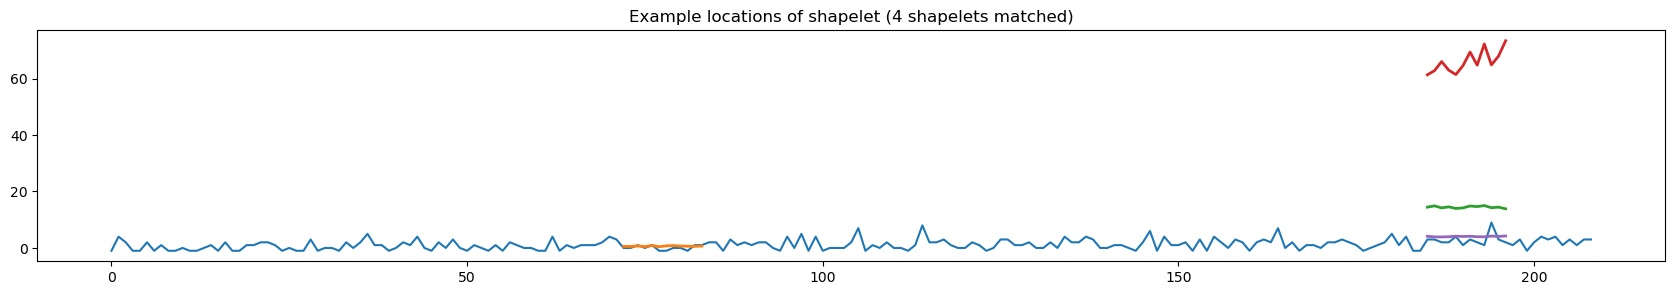

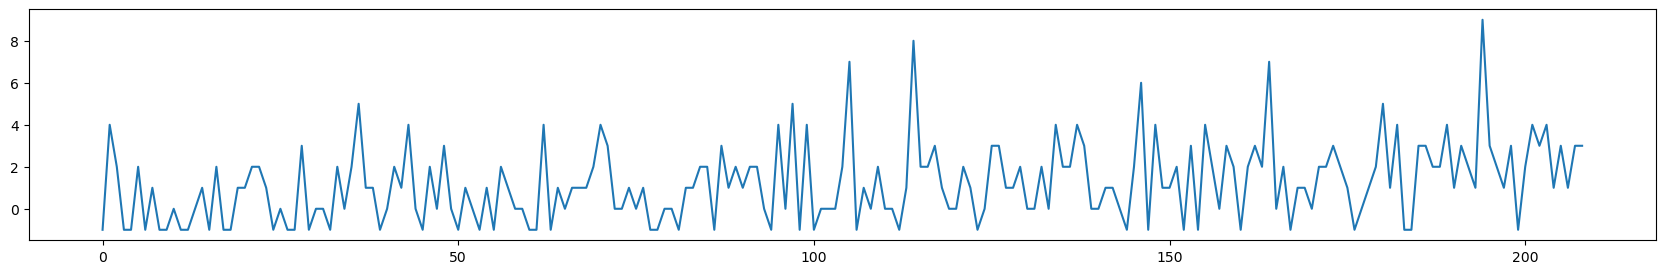

In [ ]:
ts_id = 1
plt.figure(figsize=(21.,3.))
n_shapelets = sum(shapelet_sizes.values())


plt.plot(X_test[ts_id].ravel())
count = 0
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    if t0 > 0:
        plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
        count+=1
plt.title("Example locations of shapelet ({} shapelets matched)".format(count))

plt.show()
plt.figure(figsize=(21.,3.))
plt.plot(X_test[ts_id].ravel())
plt.show()


NameError: name 'X' is not defined

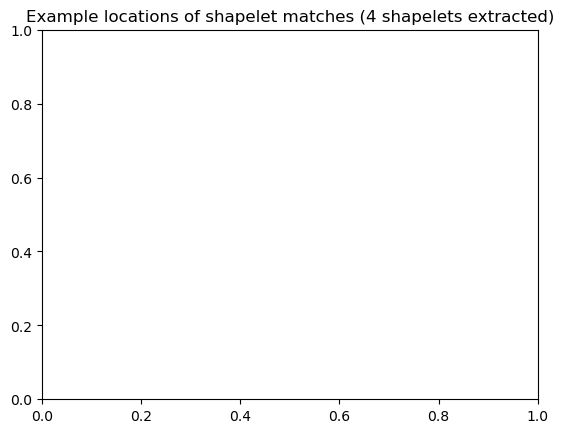

In [ ]:
ts_id = 0
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title(f"""Example locations of shapelet matches ({n_shapelets} shapelets extracted)""")

plt.plot(X[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)